In [1]:
import numpy as np
from lib.models.diffusion_model import CategoricalDiffusionModel
from lib.config.config_mnist import get_config
import lib.models.model_utils as model_utils
import lib.optimizer.optimizer as optim
import lib.networks.networks_utils as networks_utils
import lib.utils.bookkeeping as bookkeeping
import lib.datasets.datasets_utils as datasets_utils
from lib.datasets.datasets import get_dataloader
import lib.utils.utils as utils
import flax
import jax
import jax.numpy as jnp
from tqdm import tqdm
import os
from flax import linen as nn

/Users/paulheller/PythonRepositories/Master-Thesis/diffvenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_resume = False

if not train_resume:
    config = get_config()
    bookkeeping.save_config(config, config.save_dir)

else:
    path = 'SavedModels/MNIST'
    date = '2023-09-16'
    config_name = 'config_001.yaml'
    config_path = os.path.join(path, date, config_name)

    config = bookkeeping.load_config(config_path)

train_ds = datasets_utils.numpy_iter(get_dataloader(config, "train"))

optimizer = optim.build_optimizer(config)
fwd_model = model_utils.build_fwd_model(config)
net = networks_utils.build_network(config)
backwd_model = model_utils.build_backwd_model(config, fwd_model, net)

model = CategoricalDiffusionModel(config, fwd_model, backwd_model, optimizer)

global_key = jax.random.PRNGKey(42)
global_key, model_key = jax.random.split(global_key, 2)

# struct with step, params state, optimizer state, ema state
state = model_utils.init_state(config, model, model_key)
print("Number of parameters:", sum(x.size for x in jax.tree_util.tree_leaves(state.params)))

if train_resume:
    load_dir = 'SavedModels/MNIST'
    date = '2023-09-16'
    model_name = 'model_10'
    checkpoint_path = os.path.join(path, date, model_name)
    state = bookkeeping.load_state(state, checkpoint_path)
    config.total_train_steps = 10
    config.sample_freq = 10
    config.checkpoint_freq = 10

init_step = state.step
#state = flax.jax_utils.replicate(state)


# replicate state over several devices: if one nothing happens
# every device, process, got different rng key
process_rng_key = jax.random.fold_in(global_key, jax.process_index())
# functions over several devices
#train_step_fn = jax.pmap(train_step_fn, axis_name="shard")

train_step_fn = model.training_step
#train_step_fn = jax.jit(train_step_fn)
lr_schedule = optim.build_lr_schedule(config)

n_samples = 16



Number of parameters: 1449376


  0%|          | 0/3 [00:00<?, ?it/s]

Iteration: 1
calc loss


 33%|███▎      | 1/3 [01:00<02:00, 60.06s/it]

updated state
Iteration: 2
calc loss


 67%|██████▋   | 2/3 [01:24<00:38, 38.98s/it]

updated state
Iteration: 3
calc loss
updated state
Sampling


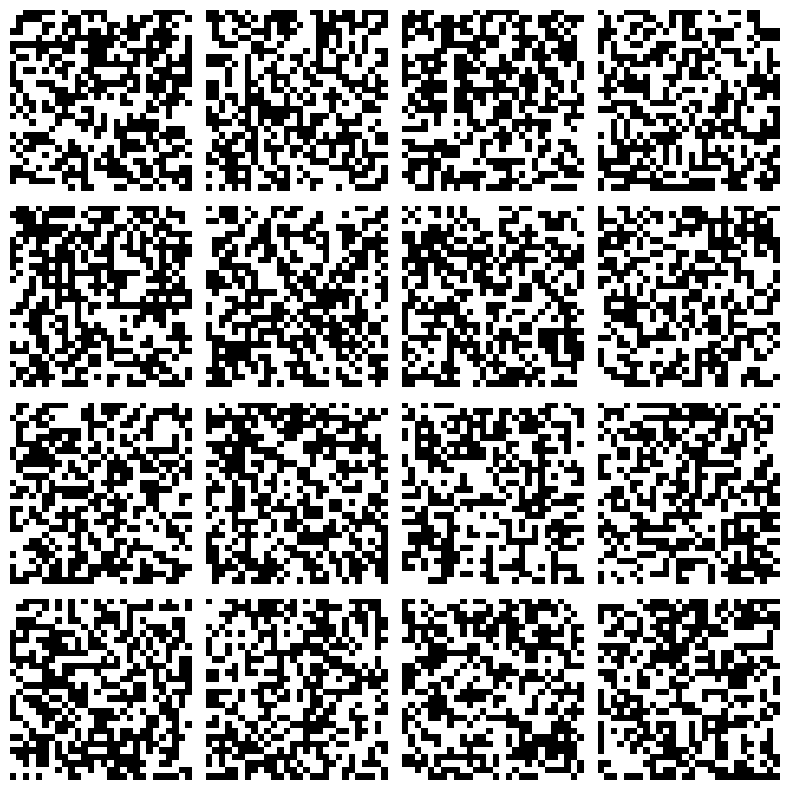

100%|██████████| 3/3 [02:28<00:00, 49.42s/it]


In [3]:

for step in tqdm(range(init_step + 1, config.total_train_steps + 1)):
    print("Iteration:", step)

    #batch = fn_data_preprocess(next(train_ds))
    batch = next(train_ds)
    
    process_rng_key = jax.random.fold_in(process_rng_key, step)
    # for cpu: step_rng_keys = process_rng_key
    step_rng_keys = utils.shard_prng_key(process_rng_key)
    
    state, aux = train_step_fn(state, global_key, batch)

    #if step % config.log_every_steps == 0:
    #    aux = jax.device_get(flax.jax_utils.unreplicate(aux))
    #    aux["train/lr"] = lr_schedule(step)
    if (step) % config.checkpoint_freq == 0 or step == config.total_train_steps:
        bookkeeping.save_model(config.save_dir, state, step)

    if step % config.sample_freq == 0 or step == config.total_train_steps:
        samples = model.sample_loop(state, process_rng_key, n_samples, conditioner=None)
        #  samples = utils.all_gather(samples)
        samples = jnp.reshape(samples, (n_samples, 1, 28, 28))
        saving_plot_path = os.path.join(config.sample_plot_path, f"samples_epoch_{step}.png")
        datasets_utils.plot_mnist_batch(samples, saving_plot_path)
        
    